In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader

## Configuring sacred 

In [97]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(
                    root='./data/trainset/',
                    transform=transforms
                    )

test_data = torchvision.datasets.ImageFolder(
                    root= './data/test/', 
                    transform=transforms)

dataset_ratio = np.array([95, 5])/100

sizes = [int(x*len(data)) for x in dataset_ratio]
sizes[0] += len(data) - sum(sizes)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset=data, lengths=sizes)

train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True
                    )

valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True
                    )

test_loader = torch.utils.data.DataLoader(
                    test_data,
                    batch_size=64,
                    num_workers=2,
                    shuffle=False
                    )
print(data)
print(valid_dataset)

Dataset ImageFolder
    Number of datapoints: 19998
    Root Location: ./data/trainset/
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [100]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


## Hyper-parameters of the model

In [98]:
learning_rate = 1e-3
lr0 = 0.02
optim = 'sgd'
num_epochs = 10
store_every = 200

In [99]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(256, 2)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

## First Implementation

In [101]:
model = Classifier()
if cuda_available:
    model = clf.cuda()
if optim == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
elif optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [104]:
def trainer1():
    for epoch in range(epoches):
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())


            if batch_idx%50==0:
                print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

        # Evaluate
        model.eval()
        total = 0
        correct = 0
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
        print('--------------------------------------------------------------')
        model.train()
    print('Done...')

trainer1()

Epoch : 0 Loss : 0.693 
Epoch : 0 Loss : 0.693 
Epoch : 0 Loss : 0.693 
Epoch : 0 Loss : 0.693 
Epoch : 0 Loss : 0.693 
Epoch : 0 Loss : 0.693 


KeyboardInterrupt: 

## Second implementation

In [106]:
class Trainer():
    def evaluate(dataset_loader, criterion):
        LOSSES = 0
        COUNTER = 0
        for batch in dataset_loader:
            optimizer.zero_grad()

            x, y = batch
    #             x = x.view(-1,1,28,28)
            y = y.view(-1)
            if cuda_available:
                x = x.cuda()
                y = y.cuda()

            loss = criterion(model(x), y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            COUNTER += n

        return LOSSES / float(COUNTER)
    
    def accuracy(proba, y):
        correct = torch.eq(proba.max(1)[1], y).sum().type(torch.FloatTensor)
        return correct / y.size(0)
    
    def adjust_lr(optimizer, epoch, total_epochs):
        lr = lr0 * (0.1 ** (epoch / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    def train_model():
        LOSSES = 0
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_test = list()
        for e in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()

                x, y = batch
    #             x = x.view(-1,1,28,28)
                y = y.view(-1)
                if cuda_available:
                    x = x.cuda()
                    y = y.cuda()

                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

                n = y.size(0)
                LOSSES += loss.sum().data.cpu().numpy() * n
                COUNTER += n
                ITERATIONS += 1
                if ITERATIONS%(store_every/5) == 0:
                    avg_loss = LOSSES / float(COUNTER)
                    LOSSES = 0
                    COUNTER = 0
                    print(" Iteration {}: TRAIN {}".format(
                        ITERATIONS, avg_loss))

                if ITERATIONS%(store_every) == 0:     

                    train_loss = evaluate(train_loader, criterion)
                    learning_curve_nll_train.append(train_loss)
                    test_loss = evaluate(test_loader, criterion)
                    learning_curve_nll_test.append(test_loss)

                    train_acc = evaluate(train_loader, accuracy)
                    learning_curve_acc_train.append(train_acc)
                    test_acc = evaluate(valid_loader, accuracy)
                    learning_curve_acc_test.append(test_acc)

                    print(" [NLL] TRAIN {} / TEST {}".format(
                        train_loss, test_loss))
                    print(" [ACC] TRAIN {} / TEST {}".format(
                        train_acc, test_acc))

            adjust_lr(optimizer, e+1, num_epochs)

        return learning_curve_nll_train, \
               learning_curve_nll_test, \
               learning_curve_acc_train, \
               learning_curve_acc_test, 

    nll_train, nll_test, acc_train, acc_test = train_model()
    print('Done...')

 Iteration 40: TRAIN 0.6929582223296166
 Iteration 80: TRAIN 0.6929883122444153
 Iteration 120: TRAIN 0.692905892431736
 Iteration 160: TRAIN 0.6929774180054664
 Iteration 200: TRAIN 0.6929300889372826
 [NLL] TRAIN 0.6929395632829419 / TEST 0.6941686435970551
 [ACC] TRAIN 0.5501342175653015 / TEST 0.5345345349820169
 Iteration 240: TRAIN 0.692963969707489
 Iteration 280: TRAIN 0.6929215237498283
 Iteration 320: TRAIN 0.6929481659202845
 Iteration 360: TRAIN 0.6929797753691673
 Iteration 400: TRAIN 0.6929910778999329
 [NLL] TRAIN 0.6929284893774322 / TEST 0.6985188487840428
 [ACC] TRAIN 0.5002368545744305 / TEST 0.49549549558499195
 Iteration 440: TRAIN 0.6930780485272408
 Iteration 480: TRAIN 0.6929617375135422
 Iteration 520: TRAIN 0.6928420841693879
 Iteration 560: TRAIN 0.6930610403418541
 Iteration 600: TRAIN 0.693016835564681
 [NLL] TRAIN 0.6928824232317183 / TEST 0.6930201401660909
 [ACC] TRAIN 0.574135480817917 / TEST 0.5595595595893917
 Iteration 640: TRAIN 0.6929360881447792
 

14


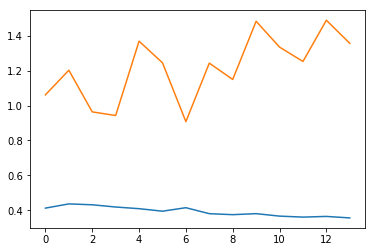

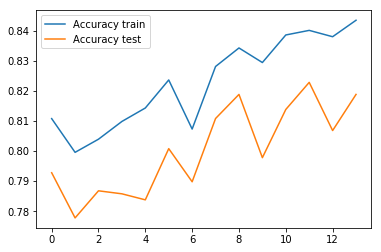

In [85]:
print(len(acc_train))
plt.figure(1)
plt.plot(range(len(nll_train)), nll_train, label="NLL train" )
plt.plot(range(len(nll_test)), nll_test,   label="NLL test" )
plt.figure(2)
plt.plot(range(len(acc_train)), acc_train, label="Accuracy train" )
plt.plot(range(len(acc_test)), acc_test,   label="Accuracy test" )
plt.legend()
plt.show()

## Evaluating of testset 

In [148]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = clf(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

## Creating submission csv file

In [149]:
df = pd.DataFrame({ 'id': range(1, len(results)+1),
                    'label': results})
df['label'].replace([0,1], ['Cat','Dog'], inplace=True)
df[df.columns].to_csv('submisstion.csv',index=False)
print('Done...')

Done...
